This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray powered plotting

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import wradlib
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

### Read a polar data set from the German Weather Service

In [2]:
filename = wradlib.util.get_wradlib_data_file('dx/raa00-dx_10908-0806021735-fbg---bin.gz')
print(filename)

/home/travis/build/wradlib/wradlib-notebooks/wradlib-data/dx/raa00-dx_10908-0806021735-fbg---bin.gz


In [3]:
img, meta = wradlib.io.read_dx(filename)

Inspect the data set a little

In [4]:
print("Shape of polar array: %r\n" % (img.shape,))
print("Some meta data of the DX file:")
print("\tdatetime: %r" % (meta["datetime"],))
print("\tRadar ID: %s" % (meta["radarid"],))

Shape of polar array: (360, 128)

Some meta data of the DX file:
	datetime: datetime.datetime(2008, 6, 2, 17, 35, tzinfo=<UTC>)
	Radar ID: 10908


### transform to xarray DataArray

In [5]:
r = np.arange(img.shape[1], dtype=np.float)
r += (r[1] - r[0]) / 2.
az = meta['azim']
az += (az[1] - az[0]) / 2.
da = wradlib.georef.create_xarray_dataarray(img, r=r, phi=az, theta=meta['elev'])
da = wradlib.georef.georeference_dataset(da)

In [6]:
da

<xarray.DataArray (azimuth: 360, range: 128)>
array([[  0. , -24. , -21. , ...,  28.5,  29. ,  35. ],
       [-13.5, -22. , -17. , ...,  15. ,   7. ,   3.5],
       [-32.5, -32.5, -32.5, ...,   6. ,   8.5,   9.5],
       ...,
       [  0.5, -17.5, -23. , ...,  33. ,  32.5,  29. ],
       [-11. , -21. , -20. , ...,  36. ,  34.5,  32.5],
       [-15. , -24. , -20.5, ...,  39. ,  37. ,  38. ]])
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * range       (range) float64 0.5 1.5 2.5 3.5 4.5 ... 124.5 125.5 126.5 127.5
    elevation   (azimuth) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.2 0.2 0.1 0.1
    longitude   float64 0.0
    latitude    float64 0.0
    altitude    float64 0.0
    sweep_mode  <U20 'azimuth_surveillance'
    x           (azimuth, range) float64 0.004363 0.01309 ... -1.104 -1.113
    y           (azimuth, range) float64 0.5 1.5 2.5 3.5 ... 125.5 126.5 127.5
    z           (azimuth, range) float64 0.0008727 0.002618 ... 0.2217 0.2235
    gr          (azimuth, range) float64 0.5 1.5 2.5 3.5 ... 125.5 126.5 127.5
    rays        (azimuth, range) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float64 0.5 1.5 2.5 3.5 ... 125.5 126.5 127.5

### The simplest way to plot this dataset

Use the `wradlib` xarray DataArray Accessor

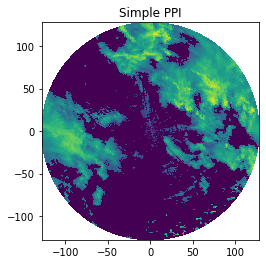

In [7]:
pm = da.wradlib.plot_ppi()
txt = pl.title('Simple PPI')

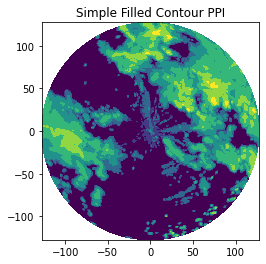

In [8]:
pm = da.wradlib.contourf()
txt = pl.title('Simple Filled Contour PPI')

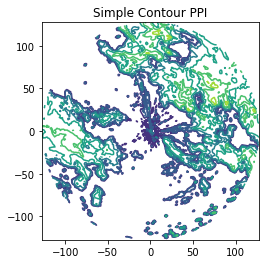

In [9]:
pm = da.wradlib.contour()
txt = pl.title('Simple Contour PPI')

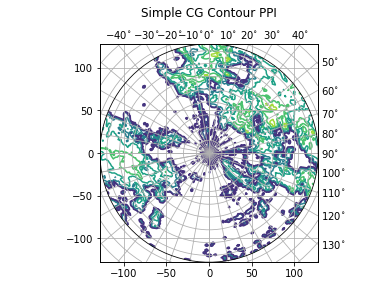

In [10]:
da = wradlib.georef.create_xarray_dataarray(img, r=r, phi=az, theta=meta['elev'])
da = wradlib.georef.georeference_dataset(da)
pm = da.wradlib.contour(proj='cg')
txt = pl.title('Simple CG Contour PPI')
txt.set_y(1.1)

### create DataArray with proper azimuth/range dimensions

Using ranges in meters and correct site-location in (lon, lat, alt)

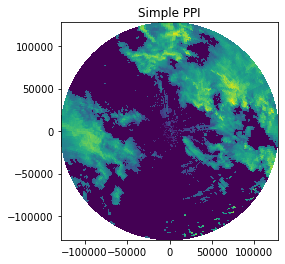

In [11]:
r = np.arange(img.shape[1], dtype=np.float) * 1000.
r += (r[1] - r[0]) / 2.
az = meta['azim']
az += (az[1] - az[0]) / 2.

da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'], 
                                            site=(10, 45, 0))
da = wradlib.georef.georeference_dataset(da)

pm = da.wradlib.plot_ppi()
txt = pl.title('Simple PPI')

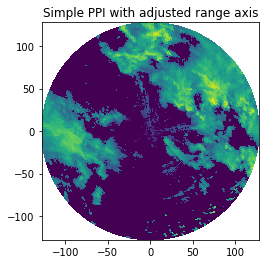

In [12]:
da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'], 
                                            site=(10, 45, 0), rf=1e3)
da = wradlib.georef.georeference_dataset(da)

pm = da.wradlib.plot_ppi()
txt = pl.title('Simple PPI with adjusted range axis')

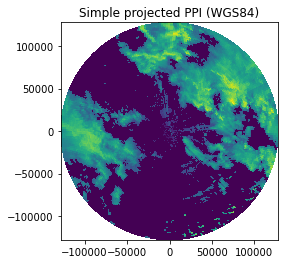

In [13]:
da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'], 
                                            proj=wradlib.georef.get_default_projection(),
                                            site=(10, 45, 0))
da = wradlib.georef.georeference_dataset(da)
pm = da.wradlib.plot_ppi()
txt = pl.title('Simple projected PPI (WGS84)')

### Plotting just one sector

For this purpose, we slice azimuth/range...

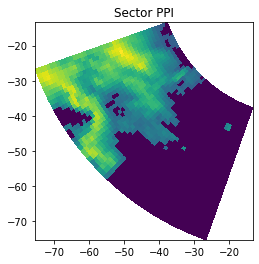

In [14]:
da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'], rf=1e3)
da = wradlib.georef.georeference_dataset(da)
da_sel = da.sel(azimuth=slice(200,250), 
                range=slice(40, 80))
pm = da_sel.wradlib.plot_ppi()
txt = pl.title('Sector PPI')

### Adding a crosshair to the PPI 

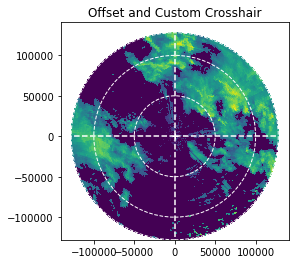

In [15]:
# We introduce a site offset...
site = (10., 45., 0)
r = np.arange(img.shape[1], dtype=np.float)
r += (r[1] - r[0]) / 2.
r *= 1000
az = np.arange(img.shape[0], dtype=np.float)
az += (az[1] - az[0]) / 2.
da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'],
                                            site=(10, 45, 0))
da = wradlib.georef.georeference_dataset(da)
da.wradlib.plot_ppi()
# ... plot a crosshair over our data...
wradlib.vis.plot_ppi_crosshair(site=site, ranges=[50e3, 100e3, 128e3], 
                               angles=[0, 90, 180, 270], 
                               line=dict(color='white'), 
                               circle={'edgecolor': 'white'})
pl.title('Offset and Custom Crosshair')
pl.axis("tight")
pl.axes().set_aspect('equal')

### Placing the polar data in a projected Cartesian reference system

Using the `proj` keyword we tell the function to:
- interpret the site coordinates as longitude/latitude
- reproject the coordinates to the given projection (here: dwd-radolan composite coordinate system)

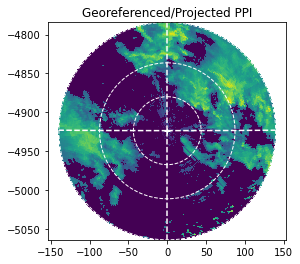

In [16]:
site=(10., 45., 0)
r = np.arange(img.shape[1], dtype=np.float)
r += (r[1] - r[0]) / 2.
r *= 1000
az = np.arange(img.shape[0], dtype=np.float)
az += (az[1] - az[0]) / 2.
proj_rad = wradlib.georef.create_osr("dwd-radolan")
da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'], 
                                            site=site)
da = wradlib.georef.georeference_dataset(da, proj=proj_rad)
pm = da.wradlib.plot_ppi()
ax = pl.gca()
# Now the crosshair ranges must be given in meters
wradlib.vis.plot_ppi_crosshair(site=site,
                               ax=ax,
                               ranges=[40e3, 80e3, 128e3],
                               line=dict(color='white'),
                               circle={'edgecolor':'white'},
                               proj=proj_rad
                               )
pl.title('Georeferenced/Projected PPI')
pl.axis("tight")
pl.axes().set_aspect('equal')

### Some side effects of georeferencing

Transplanting the radar virtually moves it away from the central meridian of the projection (which is 10 degrees east). Due north now does not point straight upwards on the map.

The crosshair shows this: for the case that the lines should actually become curved, they are implemented as a piecewise linear curve with 10 vertices. The same is true for the range circles, but with more vertices, of course.

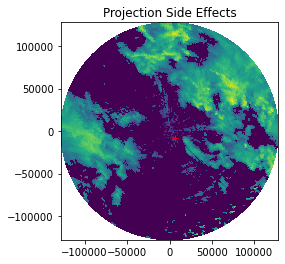

In [17]:
site=(45., 7., 0.)
r = np.arange(img.shape[1], dtype=np.float) * 1000.
r += (r[1] - r[0]) / 2.
az = np.arange(img.shape[0], dtype=np.float)
az += (az[1] - az[0]) / 2.
da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'], site=site)
da = wradlib.georef.georeference_dataset(da)
pm = da.wradlib.plot_ppi()
ax = wradlib.vis.plot_ppi_crosshair(site=site,
                                    ranges=[64e3, 128e3],
                                    line=dict(color='red'),
                                    circle={'edgecolor': 'red'},
                                    proj=proj_rad
                                   )
txt = pl.title('Projection Side Effects')

### Simple Plot on Mercator-Map using cartopy 

In [18]:
import cartopy.crs as ccrs
ccrs
site=(7, 45, 0.)
map_proj = ccrs.Mercator(central_longitude=site[1])

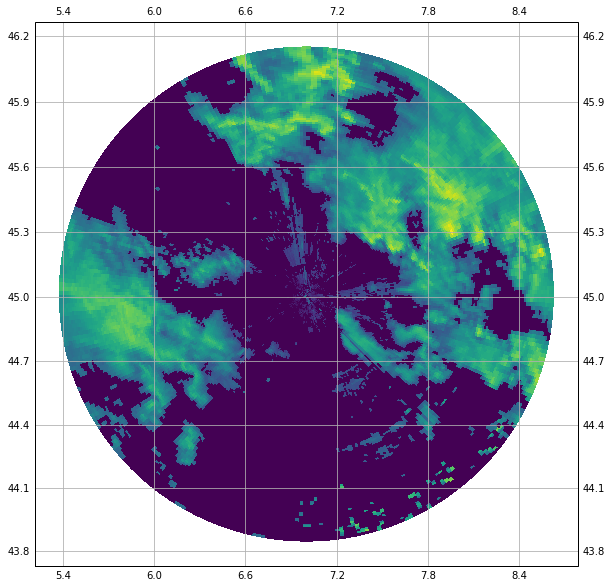

In [19]:
r = np.arange(img.shape[1], dtype=np.float) * 1000.
r += (r[1] - r[0]) / 2.
az = np.arange(img.shape[0], dtype=np.float)
az += (az[1] - az[0]) / 2.
da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'], 
                                            site=site)
da = wradlib.georef.georeference_dataset(da)
fig = pl.figure(figsize=(10, 10))
pm = da.wradlib.plot_ppi(proj=map_proj, fig=fig)
ax = pl.gca()
ax.gridlines(draw_labels=True)

### More decorations and annotations

You can annotate these plots by using standard matplotlib methods.

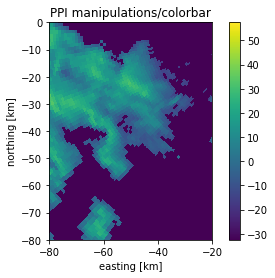

In [20]:
r = np.arange(img.shape[1], dtype=np.float)
r += (r[1] - r[0]) / 2.
az = np.arange(img.shape[0], dtype=np.float)
az += (az[1] - az[0]) / 2.

da = wradlib.georef.create_xarray_dataarray(img, phi=az, r=r, theta=meta['elev'])
da = wradlib.georef.georeference_dataset(da)
pm = da.wradlib.plot_ppi()
ax = pl.gca()
ylabel = ax.set_xlabel('easting [km]')
ylabel = ax.set_ylabel('northing [km]')
title = ax.set_title('PPI manipulations/colorbar')
# you can now also zoom - either programmatically or interactively
xlim = ax.set_xlim(-80, -20)
ylim = ax.set_ylim(-80, 0)
# as the function returns the axes- and 'mappable'-objects colorbar needs, adding a colorbar is easy
cb = pl.colorbar(pm, ax=ax)